In [1]:
import numpy as np
import _pickle as cPickle
import os
import gzip


# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    # <JAB>
    return sigmoid(x) * (1 - sigmoid(x))
    # </JAB>

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # <JAB>
    return 1 - np.square(tanh(x))
    # </JAB>

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # <JAB>
    return np.where(x < 0, 0, 1)
    # </JAB>

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)


# then define an activation function class
class Activation(object):

    def __init__(self, tname):
        
        self.func = tname
        
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')

    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)

    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)
    
    # <JAB>
    def params(self):
        return self.func
    # </JAB>

# define a base class for layers
class Layer(object):

    def fprop(self, input):
        """ Calculate layer output for given input
            (forward propagation).
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient
            with respect to weights and bias (backpropagation).
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    # <JAB>
    def layer_params(self):
        """ Return layer parameters such as number of neurons
        and activation function. Used for logging purposes
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    # </JAB>
    

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things
class Parameterized(object):

    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')


# define a container for providing input to the network
class InputLayer(Layer):

    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape



    def output_size(self):
        return self.input_shape

    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        return output_grad
    
    # <JAB>
    def layer_params(self):
        return {'neurons' : self.input_shape[1], 'activation function': 'linear'}
    # </JAB>
    
    


class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """

    def __init__(self, input_layer, num_units,
                 init_stddev=0.1, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev)
        # where num_units_prev is the number of units in the input
        # (previous) layer
        self.input_shape = input_layer.output_size()
        
        # <JAB>
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(0, init_stddev, (self.input_shape[1], num_units))
        # and this is the bias vector of shape: (num_units)
        self.b = np.zeros(self.num_units)
        # </JAB>


        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None

    def output_size(self):
        return (self.input_shape[0], self.num_units)

    def fprop(self, input):

        self.last_input = input

        # <JAB>

        a = np.dot(input, self.W) + self.b

        # The activation function can be used directly on the resulting
        # vector, as the function was "vectorized"  directly in the Activation
        # class
        h = a
        if self.activation_fun is not None :
            h = self.activation_fun.fprop(a)

        return h
        # </JAB>

    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """

        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # NOTE: you should also handle the case were
        #       activation_fun is None (meaning no activation)
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        # NOTE: self.dW is also a numpy dot product
        
        # <JAB>
        dz_da = output_grad

        if self.activation_fun is not None :
            dz_da = self.activation_fun.bprop(output_grad)

        self.dW = np.dot(self.last_input.T, dz_da)/n
        self.db = np.mean(dz_da.T, axis=1)
        
        # the gradient wrt. the input should be calculated here
        grad_input = np.dot(dz_da, self.W.T)
        
        return grad_input
        # </JAB>

    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db
    
    # <JAB>
    def layer_params(self):
        if self.activation_fun is None:
            act_fun = 'linear'
        else:
            act_fun = self.activation_fun.params()
            
        return {'neurons' : self.num_units, 'activation function': act_fun}
    # </JAB>


# finally we specify the interface for output layers
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()

    def output_size(self):
        return (1,)

    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )

    def input_grad(self, Y, Y_pred):
        # <JAB>
        return (Y_pred - Y)
        # </JAB>

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))
    
    # <JAB>
    def layer_params(self):
        return {'neurons' : self.input_size[1], 'activation function': 'linear'}
    # </JAB>


class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates
        the negative log likelihood as loss
        and should be used for classification.
    """

    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()

    def output_size(self):
        return (1,)

    def fprop(self, input):
        return softmax(input)

    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )

    def input_grad(self, Y, Y_pred):
        # HINT: since this would involve taking the log
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))
        #       this gradient computation can be simplified a lot,
        #       you may find a connection to the LinearOutput layer!

        # <JAB>
        return (Y_pred - Y)
        # </JAB>

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable
        # you should add an epsilon in the log ;)
        eps = 1e-10

        # <JAB>
        loss = np.sum(- np.log(eps * Y_pred) * Y, axis=1)
        # </JAB>
        return np.mean(loss)
    
    # <JAB>
    def layer_params(self):
        return {'neurons' : self.input_size[1], 'activation function': 'softmax'}
    # </JAB>

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [4]:
class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers

    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """

        # <JAB>
        Y_pred = X
        for layer in self.layers :
            Y_pred = layer.fprop(Y_pred)
        # </JAB>

        return Y_pred

    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)

        for layer in list(reversed(self.layers[upto:]))[1:]:
            if isinstance(layer, Parameterized):
                next_grad = layer.bprop(next_grad)

        return next_grad

    def classification_error(self, X, Y):
        """ Calculate error on the given data
            assuming they are classes that should be predicted.
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)

    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size

        # start by extracting a batch from X and Y
        # (you can assume the inputs are already shuffled)
        # HINT: layer.params() returns parameters *by reference*
        #       so you can easily update in-place

        for b in range(n_batches):

            # <JAB>
            batch_X = X[b * batch_size : batch_size * (b + 1)]
            batch_Y = Y[b * batch_size : batch_size * (b + 1)]

            batch_Y_pred = self.predict(batch_X)

            self.backpropagate(batch_Y, batch_Y_pred)

            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()

                    W -= learning_rate * dW
                    b -= learning_rate * db
            # </JAB>

    def gd_epoch(self, X, Y, batch_size):
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        
        # <JAB>
        
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        
        
        dW_acc = []
        db_acc = []
        
        # Initialize gradient accumulators
        for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW_acc.append(np.zeros(W.shape))
                    db_acc.append(np.zeros(b.shape))
        
        
        for b in range(n_batches):
            batch_X = X[b * batch_size : batch_size * (b + 1)]
            batch_Y = Y[b * batch_size : batch_size * (b + 1)]
            
            batch_Y_pred = self.predict(batch_X)

            self.backpropagate(batch_Y, batch_Y_pred)
            
            # Accumulate Gradients
            for l, layer in enumerate(self.layers):
                if isinstance(layer, Parameterized):
                    dW, db = layer.grad_params()

                    dW_acc[l] += dW
                    db_acc[l] += db
        
        
        for l, layer in enumerate(self.layers):
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()

                    W -= dW_acc[l]
                    b -= db_acc[l]
        # </JAB>
        

    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True, lr_decay = 1):

        # <JAB>
        train_meas = [[],[]]
        valid_meas = [[],[]]
        # </JAB>

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
            Y_valid_oh = one_hot(Y_valid)
        else:
            Y_train = Y
            Y_valid_oh = Y_valid
        print("... starting training")
        
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))
                
            
            # <JAB>
            # Reduce the Learning Rate by some percentage every epoch
            learning_rate *= lr_decay
            # </JAB>

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_error = self.classification_error(X, Y)
            #print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))

            # compute error on validation data:
            # simply make the function take validation data as input
            # and then compute errors here and print them
            
            # <JAB>
            validation_loss = self._loss(X_valid, Y_valid_oh)
            validation_error = self.classification_error(X_valid, Y_valid)
            
            train_error *= 100
            validation_error *= 100
            
            print('epoch {}, train loss {:.4f}, train error {:.4f}%, validation loss {:.4f}, validation error {:.4f}%'.format(e, train_loss, train_error, validation_loss, validation_error))

            train_meas[0].append(train_loss)
            train_meas[1].append(train_error)
            valid_meas[0].append(validation_loss)
            valid_meas[1].append(validation_error)

        return train_meas, valid_meas, self.params(learning_rate, batch_size, descent_type)
        # </JAB>

    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    print('   checking gradient for parameter {}'.format(p))
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and
                    # computing loss and gradient with these
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))

                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params,
                          grad_given_params, param_init)
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)

                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)
                    
    # <JAB>
    def params(self, learning_rate, batch_size, optimization_alg ):
        
        if optimization_alg == 'gd':
            learning_rate = 0
            
        parameters = [{'learning rate': learning_rate, 'batch size' : batch_size, \
                    'optimization algorithm' : optimization_alg}, []]
        
        for layer in self.layers:
            parameters[1].append(layer.layer_params())
            
        return parameters
    # </JAB>

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [5]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [6]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [7]:
nn.check_gradients(X, Y)

checking gradient for layer 1
   checking gradient for parameter 0
diff scipy 1.36e-06
   checking gradient for parameter 1
diff scipy 4.59e-07
checking gradient for layer 2
   checking gradient for parameter 0
diff scipy 1.30e-06
   checking gradient for parameter 1
diff scipy 2.78e-07
checking gradient for layer 3
   checking gradient for parameter 0
diff scipy 6.81e-07
   checking gradient for parameter 1
diff scipy 2.10e-07


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [8]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [9]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [13]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))
#
#nn = NeuralNetwork(layers)
#
#
## Train neural network
#t0 = time.time()
#train_meas, valid_meas, net_config = nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.1, 
#         max_epochs=20, batch_size=100, y_one_hot=True)
#t1 = time.time() - t0
#print('Duration: {:.2f}s'.format(t1))




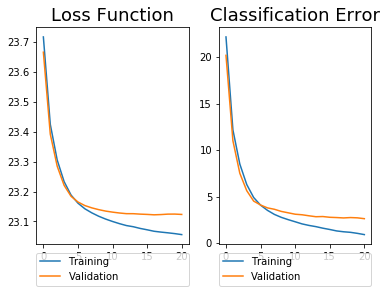

In [14]:
# Plot the results

import matplotlib as mpl
import matplotlib.pyplot as plt

figure = plt.figure()

axes = figure.add_subplot(1, 2, 1)

epochs = range(len(train_meas[0]))
axes.set_title('Loss Function', fontsize=18)
axes.plot(epochs, train_meas[0], label = 'Training')
axes.plot(epochs, valid_meas[0], label = 'Validation')

axes.legend(bbox_to_anchor=(0., -.19, 1., .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.)

axes = figure.add_subplot(1, 2, 2)

epochs = range(len(train_meas[0]))
axes.set_title('Classification Error', fontsize=18)
axes.plot(epochs, train_meas[1], label = 'Training')
axes.plot(epochs, valid_meas[1], label = 'Validation')

axes.legend(bbox_to_anchor=(0., -.19, 1., .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [11]:
# <JAB>
# Write configurations and results to a file

def train(net_configs):
    
    net_path = './networks.txt'
    train_path = './training.txt'
    
    if not os.path.exists(net_path):
        net_file = open(net_path, 'w')
        net_file.write('Neural Network Configurations:\n')
        net = 1
    else:
        net_file = open(net_path, 'r')
        
        lines = net_file.read().splitlines()
        last_line = lines[-1]
        
        net_file.close()
        
        net_file = open(net_path, 'a')
        
        net = int(last_line.split(',')[0].split(':')[1]) + 1;
        
    if not os.path.exists(train_path):
        train_file = open(train_path, 'w')
        train_file.write('Learning Curves:\n')
        train_file.write('Net:, Epoch:, Train Loss:, Train Error:,  Validation Loss:, Validation Error:\n')
    else:
        train_file = open(train_path, 'a')
    
    n = 0
    for config in net_configs:
        
        print('\n\nTesting Neural Network model ', n)
        print(config['comment'])
        
        lr = config['learning_rate']
        me = config['max_epochs']
        bs = config['batch_size']
        dt = config['descent_type']
        lrd = config['lr_decay']
        
        layers = []
        layers.append(InputLayer((None, 28 * 28)))
        for layer_config in config['layers']:
            
            if layer_config['act_fun'] is not None:
                af = Activation(layer_config['act_fun'])
            else:
                af = None
            
            layers.append(FullyConnectedLayer(layers[-1],num_units=layer_config['units'],
                                              init_stddev=layer_config['init_sd'],
                                              activation_fun=af))
        
        if config['out_function'] == 'sm':
            layers.append(SoftmaxOutput(layers[-1]))
        elif config['out_function'] == 'li':
            layers.append(LinearOutput(layers[-1]))
        
        
        nn = NeuralNetwork(layers)


        # Train neural network
        t0 = time.time()
        train_meas, valid_meas, net_config = nn.train(X_train, y_train, X_valid, y_valid, learning_rate=lr, 
         max_epochs=me, batch_size=bs, y_one_hot=True, descent_type=dt, lr_decay=lrd)
        t1 = time.time() - t0


        
        # Write results to file
        net_file.write('net: ' + str(net + n) + ', [' + config['comment'] + '], t: ' + str(t1) + ', ')
        
        for key, value in net_config[0].items():
            net_file.write(key + ': ' + str(value) + '; ')
        
        for l, layer in enumerate(net_config[1]):
            net_file.write('Layer ' + str(l) + ': ')
            for key, value in layer.items():
                 net_file.write(key + ': ' + str(value) + ', ')
            net_file.write('; ')
        net_file.write('\n')
        
        
        for i in range(len(train_meas[0])):
            train_file.write(str(net + n) + ',' + str(i) + ',' + str(train_meas[0][i]) + ',' + \
                             str(train_meas[1][i]) + ',' + str(valid_meas[0][i]) + ',' + str(valid_meas[1][i]) + '\n')
        
        n += 1
        
    net_file.close()
    train_file.close()



def sd(units):
    return 1 / (2 * np.sqrt(units))
            

In [138]:
neural_networks = [
    {
        'comment'      : 'Test network: only 5 epochs', 
        'learning_rate': 0.1,
        'max_epochs'   : 5,
        'batch_size'   : 64,
        'out_function' : 'li',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # Original NN
    {
        'comment'      : 'Original network',
        'learning_rate': 0.1,
        'max_epochs'   : 20,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # Added epochs
    {
        'comment'      : 'Original Network with 50 epochs',
        'learning_rate': 0.1,
        'max_epochs'   : 50,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # Changed sd for initialization of parameters
    {
        'comment'      : 'Original Network with stddev set to 1/(2 * sqrt(units)',
        'learning_rate': 0.1,
        'max_epochs'   : 20,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : sd(100), 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : sd(100), 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' :  sd(10), 'act_fun' :   None},
        ]
    },
    
    
    # Changed learning rate
    {
        'comment'      : 'Original Network with learning rate of 0.15',
        'learning_rate': 0.15,
        'max_epochs'   : 20,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # Changed learning rate
    {
        'comment'      : 'Original Network with learning rate of 0.3',
        'learning_rate': 0.3,
        'max_epochs'   : 20,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # Added Layer
    {
        'comment'      : 'Original Network with more layers and different activation functions',
        'learning_rate': 0.15,
        'max_epochs'   : 20,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' :    'relu'},
            {'units' : 200, 'init_sd' : 0.1, 'act_fun' : 'sigmoid'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' :    'tanh'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :      None},
        ]
    },
    
    # Original NN with larger batch size
    {
        'comment'      : 'Original network with batch size of 100',
        'learning_rate': 0.1,
        'max_epochs'   : 20,
        'batch_size'   : 100,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # NN5 with 40 epochs
    {
        'comment'      : 'NN5 with 40 epochs',
        'learning_rate': 0.3,
        'max_epochs'   : 40,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # NN5 with 60 epochs
    {
        'comment'      : 'NN5 with 60 epochs',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # NN10 with batch size 100
    {
        'comment'      : 'NN10 with batch size 100',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 100,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    # NN11 with epocs 80
    {
        'comment'      : 'NN10 with batch size 100',
        'learning_rate': 0.3,
        'max_epochs'   : 80,
        'batch_size'   : 100,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
]

In [139]:
train(neural_networks)



Testing Neural Network model  0
Test network: only 5 epochs
... starting training
epoch 0, train loss 0.1184, train error 9.3960%, validation loss 0.1117, validation error 8.4800%
epoch 1, train loss 0.0919, train error 7.2760%, validation loss 0.0874, validation error 6.6400%
epoch 2, train loss 0.0786, train error 6.0700%, validation loss 0.0755, validation error 5.7100%
epoch 3, train loss 0.0697, train error 5.3200%, validation loss 0.0677, validation error 5.1700%
epoch 4, train loss 0.0635, train error 4.8680%, validation loss 0.0623, validation error 4.8200%
epoch 5, train loss 0.0586, train error 4.4900%, validation loss 0.0582, validation error 4.5700%


Testing Neural Network model  1
Original network
... starting training
epoch 0, train loss 23.2712, train error 7.5440%, validation loss 23.2588, validation error 6.8300%
epoch 1, train loss 23.1880, train error 4.9220%, validation loss 23.1882, validation error 4.7400%
epoch 2, train loss 23.1498, train error 3.7760%, valid

epoch 0, train loss 23.2752, train error 7.6360%, validation loss 23.2580, validation error 6.7600%
epoch 1, train loss 23.1935, train error 5.1240%, validation loss 23.1897, validation error 4.7200%
epoch 2, train loss 23.1523, train error 3.8960%, validation loss 23.1583, validation error 3.8600%
epoch 3, train loss 23.1268, train error 3.1160%, validation loss 23.1399, validation error 3.3600%
epoch 4, train loss 23.1097, train error 2.5860%, validation loss 23.1295, validation error 3.0400%
epoch 5, train loss 23.0990, train error 2.2600%, validation loss 23.1253, validation error 2.9000%
epoch 6, train loss 23.0885, train error 1.9580%, validation loss 23.1207, validation error 2.8900%
epoch 7, train loss 23.0793, train error 1.6440%, validation loss 23.1165, validation error 2.6800%
epoch 8, train loss 23.0723, train error 1.4080%, validation loss 23.1144, validation error 2.5700%
epoch 9, train loss 23.0672, train error 1.2760%, validation loss 23.1140, validation error 2.5000%


epoch 16, train loss 23.0439, train error 0.5580%, validation loss 23.1308, validation error 2.5400%
epoch 17, train loss 23.0414, train error 0.4700%, validation loss 23.1318, validation error 2.4800%
epoch 18, train loss 23.0394, train error 0.4040%, validation loss 23.1323, validation error 2.4700%
epoch 19, train loss 23.0375, train error 0.3260%, validation loss 23.1329, validation error 2.5000%
epoch 20, train loss 23.0357, train error 0.2560%, validation loss 23.1331, validation error 2.4400%


Testing Neural Network model  7
Original network with batch size of 100
... starting training
epoch 0, train loss 23.3049, train error 8.3580%, validation loss 23.2822, validation error 7.6100%
epoch 1, train loss 23.2211, train error 5.8200%, validation loss 23.2132, validation error 5.3400%
epoch 2, train loss 23.1754, train error 4.4120%, validation loss 23.1783, validation error 4.2200%
epoch 3, train loss 23.1469, train error 3.5300%, validation loss 23.1585, validation error 3.7900%

epoch 12, train loss 23.0547, train error 0.9360%, validation loss 23.1625, validation error 2.8500%
epoch 13, train loss 23.0532, train error 0.8880%, validation loss 23.1580, validation error 2.7500%
epoch 14, train loss 23.0420, train error 0.5620%, validation loss 23.1588, validation error 2.5700%
epoch 15, train loss 23.0508, train error 0.7040%, validation loss 23.1689, validation error 2.5400%
epoch 16, train loss 23.0573, train error 0.9680%, validation loss 23.1798, validation error 2.9100%
epoch 17, train loss 23.0314, train error 0.1860%, validation loss 23.1499, validation error 2.3300%
epoch 18, train loss 23.0297, train error 0.1220%, validation loss 23.1469, validation error 2.1800%
epoch 19, train loss 23.0275, train error 0.0360%, validation loss 23.1471, validation error 2.1500%
epoch 20, train loss 23.0264, train error 0.0000%, validation loss 23.1419, validation error 2.1000%
epoch 21, train loss 23.0263, train error 0.0000%, validation loss 23.1433, validation erro

In [15]:
neural_networks = [
    {
        'comment'      : 'Original Network with learning rate of 0.30 and batch size of 64 and 60 epochs and lr decay of 0.99',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'lr_decay'     : 0.99,
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    {
        'comment'      : 'Original Network with learning rate of 0.30 and batch size of 64 and 60 epochs and lr decay of 0.98',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'lr_decay'     : 0.98,
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    {
        'comment'      : 'Original Network with learning rate of 0.30 and batch size of 64 and 60 epochs and lr decay of 0.97',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'lr_decay'     : 0.97,
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
    
    {
        'comment'      : 'Original Network with learning rate of 0.30 and batch size of 64 and 60 epochs and lr decay of 0.96',
        'learning_rate': 0.3,
        'max_epochs'   : 60,
        'batch_size'   : 64,
        'out_function' : 'sm',
        'descent_type' : 'sgd',
        'lr_decay'     : 0.96,
        'layers': [
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' : 100, 'init_sd' : 0.1, 'act_fun' : 'relu'},
            {'units' :  10, 'init_sd' : 0.1, 'act_fun' :   None},
        ]
    },
]

train(neural_networks)



Testing Neural Network model  0
Original Network with learning rate of 0.30 and batch size of 64 and 60 epochs and lr decay of 0.99
... starting training
epoch 0, train loss 23.1959, train error 5.1540%, validation loss 23.1995, validation error 5.1400%
epoch 1, train loss 23.1368, train error 3.4580%, validation loss 23.1563, validation error 3.8800%
epoch 2, train loss 23.1233, train error 3.0780%, validation loss 23.1546, validation error 3.8100%
epoch 3, train loss 23.1008, train error 2.4120%, validation loss 23.1411, validation error 3.3000%
epoch 4, train loss 23.0822, train error 1.8180%, validation loss 23.1322, validation error 2.9900%
epoch 5, train loss 23.0742, train error 1.5640%, validation loss 23.1341, validation error 2.9500%
epoch 6, train loss 23.0685, train error 1.4820%, validation loss 23.1342, validation error 2.7800%
epoch 7, train loss 23.0654, train error 1.3640%, validation loss 23.1366, validation error 2.7800%
epoch 8, train loss 23.0548, train error 0.9

epoch 18, train loss 23.0273, train error 0.0100%, validation loss 23.1333, validation error 2.0500%
epoch 19, train loss 23.0271, train error 0.0080%, validation loss 23.1340, validation error 2.0400%
epoch 20, train loss 23.0270, train error 0.0040%, validation loss 23.1347, validation error 2.0600%
epoch 21, train loss 23.0269, train error 0.0040%, validation loss 23.1353, validation error 2.0800%
epoch 22, train loss 23.0268, train error 0.0040%, validation loss 23.1359, validation error 2.0900%
epoch 23, train loss 23.0267, train error 0.0020%, validation loss 23.1366, validation error 2.0900%
epoch 24, train loss 23.0266, train error 0.0020%, validation loss 23.1372, validation error 2.0900%
epoch 25, train loss 23.0266, train error 0.0020%, validation loss 23.1376, validation error 2.0800%
epoch 26, train loss 23.0265, train error 0.0020%, validation loss 23.1382, validation error 2.0900%
epoch 27, train loss 23.0265, train error 0.0020%, validation loss 23.1386, validation erro

epoch 37, train loss 23.0263, train error 0.0000%, validation loss 23.1479, validation error 2.0500%
epoch 38, train loss 23.0263, train error 0.0000%, validation loss 23.1482, validation error 2.0500%
epoch 39, train loss 23.0263, train error 0.0000%, validation loss 23.1484, validation error 2.0500%
epoch 40, train loss 23.0263, train error 0.0000%, validation loss 23.1487, validation error 2.0600%
epoch 41, train loss 23.0263, train error 0.0000%, validation loss 23.1490, validation error 2.0600%
epoch 42, train loss 23.0263, train error 0.0000%, validation loss 23.1492, validation error 2.0500%
epoch 43, train loss 23.0263, train error 0.0000%, validation loss 23.1494, validation error 2.0500%
epoch 44, train loss 23.0263, train error 0.0000%, validation loss 23.1496, validation error 2.0500%
epoch 45, train loss 23.0263, train error 0.0000%, validation loss 23.1499, validation error 2.0600%
epoch 46, train loss 23.0262, train error 0.0000%, validation loss 23.1501, validation erro

epoch 56, train loss 23.0263, train error 0.0000%, validation loss 23.1478, validation error 2.1600%
epoch 57, train loss 23.0263, train error 0.0000%, validation loss 23.1478, validation error 2.1600%
epoch 58, train loss 23.0263, train error 0.0000%, validation loss 23.1479, validation error 2.1700%
epoch 59, train loss 23.0263, train error 0.0000%, validation loss 23.1480, validation error 2.1700%
epoch 60, train loss 23.0263, train error 0.0000%, validation loss 23.1481, validation error 2.1700%
